# **Выгрузка данных**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/eeg_aw_valence_effort.csv')

# **Обработка данных**

In [3]:
df = df.drop(df.columns[[0, 1, 2, 3]], axis=1)
df.dropna(inplace=True)
df

,buy,val12,val15,effort
0,0,0.05437,-0.81024,0.14033
1,0,0.18803,1.10880,0.05269
2,0,0.06618,-0.14021,0.52483
3,1,0.89158,-0.89813,0.22057
4,0,0.47358,-0.08872,0.01328
...,...,...,...,...
5897,1,-0.08974,0.30855,-0.32381
5898,0,-0.45575,-0.04902,-0.20760
5899,0,-0.15555,0.25523,0.21105
5900,0,0.70788,-0.05353,0.52069


# **Визуализация данных**

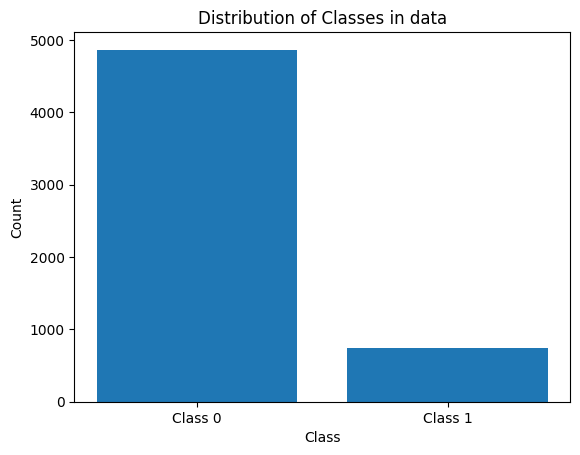

In [4]:
import matplotlib.pyplot as plt
import numpy as np


y = df['buy'].values.astype(np.float32)
count_zeros = (y == 0).sum()
count_ones = (y == 1).sum()

plt.bar([0, 1], [count_zeros, count_ones])
plt.xticks([0, 1], ['Class 0', 'Class 1'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Distribution of Classes in data')
plt.show()

# **устранение дисбаланса путем дублирования данных**

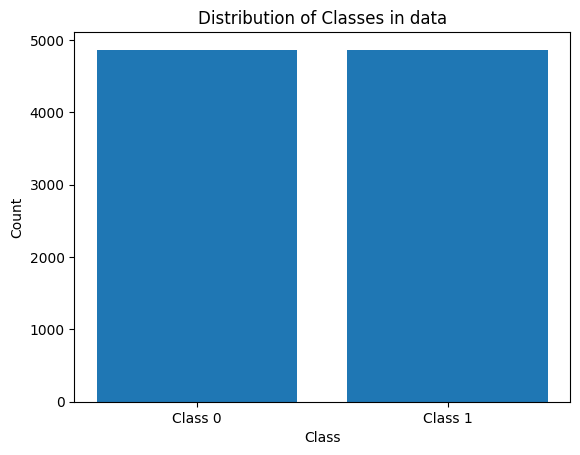

In [5]:
count_class_1 = df['buy'].sum()

class_1_data = df[df['buy'] == 1]

while len(class_1_data) < len(df[df['buy'] == 0]):
    class_1_data = pd.concat([class_1_data, class_1_data.head(len(df[df['buy'] == 0]) - len(class_1_data))])

balanced_df = pd.concat([df[df['buy'] == 0], class_1_data])


y = balanced_df['buy'].values.astype(np.float32)
count_zeros = (y == 0).sum()
count_ones = (y == 1).sum()


plt.bar([0, 1], [count_zeros, count_ones])
plt.xticks([0, 1], ['Class 0', 'Class 1'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Distribution of Classes in data')
plt.show()

# **Обучение модели**

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)


X = balanced_df[['val12', 'val15', 'effort']].values.astype(np.float32)
y = balanced_df['buy'].values.astype(np.float32)


X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_rest, y_rest, test_size=0.5, random_state=42)


X_train_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32, device=device).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32, device=device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32, device=device).view(-1, 1)

X_valid_tensor = torch.tensor(X_val, dtype=torch.float32, device=device)
y_valid_tensor = torch.tensor(y_val, dtype=torch.float32, device=device).view(-1, 1)


class DNN(nn.Module):
    def __init__(self, input_size):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 300)
        self.fc2 = nn.Linear(300, 200)
        self.fc3 = nn.Linear(200, 100)
        self.fc4 = nn.Linear(100, 50)
        self.fc5 = nn.Linear(50, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.sigmoid(self.fc5(x))
        return x


input_size = X_train.shape[1]
model = DNN(input_size).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

num_epochs = 1000
best_loss = float('inf')
best_epoch = 0

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        val_outputs = model(X_valid_tensor)
        val_loss = criterion(val_outputs, y_valid_tensor)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Valid Loss: {val_loss.item():.4f}')

    if val_loss < best_loss:
        best_loss = val_loss
        best_epoch = epoch+1
        torch.save(model.state_dict(), f'best_model.pt')


print(f'best model at epoch {best_epoch}')
final_model = DNN(input_size).to(device)
final_model.load_state_dict(torch.load('best_model.pt'))
final_model.eval()

with torch.no_grad():
    outputs = final_model(X_test_tensor)
    predicted = (outputs > 0.5).float()
    accuracy = (predicted == y_test_tensor).float().mean()
    print(f'Accuracy on test set: {accuracy.item():.4f}')

device: cpu
Epoch [1/1000], Train Loss: 0.6937, Valid Loss: 0.6840
Epoch [2/1000], Train Loss: 0.6882, Valid Loss: 0.6955
Epoch [3/1000], Train Loss: 0.6906, Valid Loss: 0.7125
Epoch [4/1000], Train Loss: 0.7272, Valid Loss: 0.6725
Epoch [5/1000], Train Loss: 0.6756, Valid Loss: 0.6905
Epoch [6/1000], Train Loss: 0.6864, Valid Loss: 0.6848
Epoch [7/1000], Train Loss: 0.6802, Valid Loss: 0.6781
Epoch [8/1000], Train Loss: 0.6746, Valid Loss: 0.6730
Epoch [9/1000], Train Loss: 0.6704, Valid Loss: 0.6678
Epoch [10/1000], Train Loss: 0.6652, Valid Loss: 0.6637
Epoch [11/1000], Train Loss: 0.6608, Valid Loss: 0.6634
Epoch [12/1000], Train Loss: 0.6609, Valid Loss: 0.6628
Epoch [13/1000], Train Loss: 0.6594, Valid Loss: 0.6626
Epoch [14/1000], Train Loss: 0.6564, Valid Loss: 0.6615
Epoch [15/1000], Train Loss: 0.6543, Valid Loss: 0.6617
Epoch [16/1000], Train Loss: 0.6532, Valid Loss: 0.6612
Epoch [17/1000], Train Loss: 0.6525, Valid Loss: 0.6599
Epoch [18/1000], Train Loss: 0.6519, Valid Lo

# **Подсчет метрик**

In [22]:
from sklearn.metrics import classification_report

with torch.no_grad():
    outputs = final_model(X_test_tensor)
    predicted = (outputs > 0.5).float()

    predicted = predicted.cpu().numpy().flatten()
    y_test_numpy = y_test_tensor.cpu().numpy().flatten()

    print(classification_report(y_test_numpy, predicted))

              precision    recall  f1-score   support

         0.0       0.94      0.76      0.84      1004
         1.0       0.79      0.94      0.86       942

    accuracy                           0.85      1946
   macro avg       0.86      0.85      0.85      1946
weighted avg       0.86      0.85      0.85      1946

